## Refs

Follow notebook `cat_dog_transfer_learning.ipynb`

In [1]:
# from google.colab import drive
# # drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

In [2]:
# !ls drive/MyDrive/ML_colab/

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [6]:
# vgg16 places365 pretrained
local_weights_file_vgg = '../pretrained/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_model_vgg = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model_vgg.load_weights(local_weights_file_vgg)

for layer in pre_trained_model_vgg.layers:
    layer.trainable = False

In [7]:
pre_trained_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
# im_dim = (200, 200)
im_dim = (150, 150)

In [9]:
last_layer_vgg = pre_trained_model_vgg.get_layer('block5_conv3')
print('last layer output shape: ', last_layer_vgg.output_shape)
last_output = last_layer_vgg.output

last layer output shape:  (None, 9, 9, 512)


In [10]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.35)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model_vgg.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [11]:
# !mv drive/MyDrive/ML_colab/datasetbeach_mountain/beach_mountain drive/MyDrive/ML_colab/dataset/

In [12]:
# only on colab
# import zipfile

# dataset_dir = 'drive/MyDrive/ML_colab/dataset'
# zip_file = dataset_dir + '/beach_mountain.zip'
# zip_ref = zipfile.ZipFile(zip_file, 'r')
# zip_ref.extractall(dataset_dir+'/b_m')
# zip_ref.close()

In [13]:
# !ls drive/MyDrive/ML_colab/dataset/b_m/beach_mountain/

In [14]:
# %%time
# import zipfile

# dataset_dir = 'drive/MyDrive/ML_colab/dataset'
# zip_file = dataset_dir + '/beach_mountain.zip'
# zip_ref = zipfile.ZipFile(zip_file, 'r')
# zip_ref.extractall("/tmp")
# zip_ref.close()

In [15]:
import os
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    lst_cat_imgs = os.listdir(SOURCE)
    lst_cat_imgs = random.sample(lst_cat_imgs, len(lst_cat_imgs))
    for file in lst_cat_imgs[:int(SPLIT_SIZE*len(lst_cat_imgs))]:
        source_file = os.path.join(SOURCE, file)
        destination_file = os.path.join(TRAINING, file)
        if os.path.getsize(source_file) > 0:
            copyfile(source_file, destination_file)
    for file in lst_cat_imgs[int(SPLIT_SIZE*len(lst_cat_imgs)):]:
        source_file = os.path.join(SOURCE, file)
        destination_file = os.path.join(TESTING, file)
        if os.path.getsize(source_file) > 0:
            copyfile(source_file, destination_file)

In [16]:
# local data

base_dir = "../dataset/beach_mountain_more"
# base_dir = "drive/MyDrive/ML_colab/dataset/beach_mountain"
# base_dir = "drive/MyDrive/ML_colab/dataset/b_m/beach_mountain/"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_beach_dir = os.path.join(train_dir, 'beach')
train_moutain_dir = os.path.join(train_dir, 'mountain')

validation_beach_dir = os.path.join(validation_dir, 'beach')
validation_mountain_dir = os.path.join(validation_dir, 'mountain')

test_beach_dir = os.path.join(test_dir, 'beach')
test_moutain_dir = os.path.join(test_dir, 'mountain')

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

batch_size = 30
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary', 
                                                    target_size = im_dim)

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size  = batch_size,
                                                         class_mode  = 'binary', 
                                                         target_size = im_dim)

Found 26446 images belonging to 2 classes.
Found 3020 images belonging to 2 classes.


In [18]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size  = batch_size,
                                                         class_mode  = 'binary', 
                                                         target_size = im_dim)

Found 929 images belonging to 2 classes.


In [19]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.96) :
            print("\nReached 96.0% accuracy so cancelling training!")
            self.model.stop_training = True

my_callback = myCallback()

In [ ]:
print("train_steps: ", validation_generator.n//validation_generator.batch_size)
print("test_steps: ", validation_generator.n//validation_generator.batch_size)

In [20]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = validation_generator.n//validation_generator.batch_size,
            epochs = 100,
            validation_steps = validation_generator.n//validation_generator.batch_size,
            verbose = 2,
            callbacks=[my_callback])

Epoch 1/100
100/100 - 32s - loss: 0.7161 - accuracy: 0.6773 - val_loss: 0.4594 - val_accuracy: 0.7823
Epoch 2/100
100/100 - 25s - loss: 0.5406 - accuracy: 0.7463 - val_loss: 0.4730 - val_accuracy: 0.7893
Epoch 3/100
100/100 - 25s - loss: 0.5069 - accuracy: 0.7567 - val_loss: 0.4319 - val_accuracy: 0.8147
Epoch 4/100
100/100 - 25s - loss: 0.4926 - accuracy: 0.7743 - val_loss: 0.4505 - val_accuracy: 0.8027
Epoch 5/100
100/100 - 25s - loss: 0.4887 - accuracy: 0.7767 - val_loss: 0.4809 - val_accuracy: 0.7897
Epoch 6/100
100/100 - 25s - loss: 0.4848 - accuracy: 0.7817 - val_loss: 0.4267 - val_accuracy: 0.8133
Epoch 7/100
100/100 - 25s - loss: 0.4524 - accuracy: 0.7860 - val_loss: 0.4239 - val_accuracy: 0.8243
Epoch 8/100
100/100 - 25s - loss: 0.4368 - accuracy: 0.8013 - val_loss: 0.4307 - val_accuracy: 0.8273
Epoch 9/100
100/100 - 25s - loss: 0.4350 - accuracy: 0.8080 - val_loss: 0.4204 - val_accuracy: 0.8173
Epoch 10/100
100/100 - 25s - loss: 0.4589 - accuracy: 0.7963 - val_loss: 0.4167 - 

In [21]:
saved_model_path = "../saved_model"

model.save(saved_model_path + '/SavedModel_100e_place_vgg16_200_moredata')
model.save(saved_model_path + '/model_100e_place_vgg16_200_moredata.h5')

# model.save("drive/MyDrive/ML_colab/save/beach_mountain/100epochs/SavedModel_100e_94")

INFO:tensorflow:Assets written to: ../saved_model/SavedModel_100e_place_vgg16_200_moredata/assets


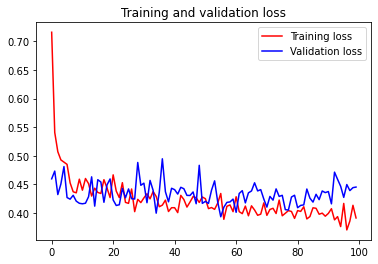

<Figure size 432x288 with 0 Axes>

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# loss
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

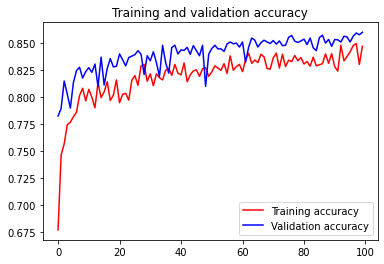

<Figure size 432x288 with 0 Axes>

In [23]:
# accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [24]:
test_generator.reset()
model.evaluate(test_generator)

31/31 [==============================] - 8s 268ms/step - loss: 0.3666 - accuracy: 0.8547


[0.36658287048339844, 0.854682445526123]

In [25]:
# check the labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'beach', 1: 'mountain'}

In [26]:
import numpy as np

In [27]:
# test_generator.reset()
# pred = model.predict(test_generator, verbose=1)
# predicted_class_indices=(pred>0.5).astype("int32")
# predictions = [labels[k[0]] for k in predicted_class_indices]
# predictions

In [28]:
im_dim

(150, 150)

In [29]:
from tensorflow.keras.preprocessing import image

In [30]:
# predict for an uploaded image
file_path = '../dataset/beach_mountain/internet/' # current dir
# file_path = '../dataset/beach_mountain/test/beach/' # current dir
# file_path = '../dataset/beach_mountain/test/mountain/' # current dir
test_files = os.listdir(file_path)

for file in test_files:
    # predicting images
    path=file_path + file
    img=image.load_img(path, target_size=im_dim)
    x=image.img_to_array(img)
    x=x/255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    classes = model.predict(images)
    classes = (classes > 0.5).astype("int32")[0][0]
#     print(classes)

    if classes>0:
        print(file + " is a mountain")
    else:
        print(file + " is a beach")

beach11.jpeg is a beach
mountain6.jpg is a mountain
mountain9.jpg is a mountain
beach9.jpg is a beach
beach12.jpeg is a mountain
beach8.jpeg is a mountain
mountain2.jpg is a mountain
mountain5.jpg is a mountain
mountain1.jpg is a mountain
mountain5.jpeg is a mountain
beach1.jpg is a mountain
mountain3.jpg is a mountain
beach5.jpeg is a beach
beach3.jpg is a beach
mountain4.png is a beach
beach6.jpg is a beach
beach10.jpeg is a beach
beach4.jpeg is a beach
beach2.jpeg is a mountain
beach7.jpeg is a mountain
mountain8.jpeg is a mountain
mountain7.jpg is a mountain


In [31]:
# from an image
test_file = "../dataset/beach_mountain/internet/mountain1.jpg"
img = image.load_img(test_file, target_size=im_dim)
x = image.img_to_array(img)
x = x/255
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images)
classes = (classes > 0.5).astype("int32")[0]

if classes>0:
    print(test_file.split("/")[-1] + " is a mountain")
else:
    print(test_file.split("/")[-1] + " is a beach")

mountain1.jpg is a mountain


In [32]:
# model.save("drive/MyDrive/ML_colab/save/beach_mountain/100epochs/model_100e_94.h5")

In [33]:
# keep colab alive
# while True:pass